In [7]:
#!/usr/bin/env python
# coding: utf-8

import json
import time

import matplotlib.pyplot as plt
import numpy as np
import obspy
import pandas as pd
import seaborn as sns
import torch
from obspy import UTCDateTime
from obspy.clients.fdsn import Client
from scipy.signal import find_peaks
from torch.utils.data import DataLoader

import seisbench.data as sbd
import seisbench.generate as sbg
import seisbench.models as sbm
from seisbench.util import worker_seeding

print("Loaded packages successfully!")

Loaded packages successfully!


In [13]:
# Load configuration from JSON file
try:
    with open('config.json', 'r') as f:
        config = json.load(f)
    print("✓ Configuration loaded successfully!")
except FileNotFoundError:
    print("✗ Error: config.json file not found!")
    raise
except json.JSONDecodeError as e:
    print(f"✗ Error: Invalid JSON in config.json: {e}")
    raise
except Exception as e:
    print(f"✗ Unexpected error loading config: {e}")
    raise

# Debug: print configuration summary
print("Configuration loaded:")
print("Training:")
print(f"  batch_size: {config['training']['batch_size']}")
print(f"  num_workers: {config['training']['num_workers']}")
print(f"  learning_rate: {config['training']['learning_rate']}")
print(f"  epochs: {config['training']['epochs']}")
print(f"  patience: {config['training']['patience']}")
print("Device:")
print(f"  use_cuda: {config['device']['use_cuda']}")
print(f"  device_id: {config['device']['device_id']}")
print("Peak detection:")
print(f"  sampling_rate: {config['peak_detection']['sampling_rate']}")
print(f"  height: {config['peak_detection']['height']}")
print(f"  distance: {config['peak_detection']['distance']}")

✓ Configuration loaded successfully!
Configuration loaded:
Training:
  batch_size: 64
  num_workers: 4
  learning_rate: 0.01
  epochs: 50
  patience: 5
Device:
  use_cuda: True
  device_id: 0
Peak detection:
  sampling_rate: 100
  height: 0.5
  distance: 100


In [14]:
# Set random seed for reproducibility
import random
import os

# Set random seed for reproducibility
seed = 0
print(f"Random seed selected: {seed}")
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

Random seed selected: 0


In [15]:
import os

# Loader the picker
try:
    model = sbm.PhaseNet.from_pretrained("stead")
    print("✓ Model loaded successfully!")
except Exception as e:
    print(f"✗ Error loading model: {e}")
    raise

✓ Model loaded successfully!


In [16]:
# Set up device
device = torch.device(f"cuda:{config['device']['device_id']}" if torch.cuda.is_available() and config['device']['use_cuda'] else "cpu")
print(f"Using device: {device}")
model.to(device)


Using device: cpu


PhaseNet(
  (inc): Conv1d(3, 8, kernel_size=(7,), stride=(1,), padding=same)
  (in_bn): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (down_branch): ModuleList(
    (0): ModuleList(
      (0): Conv1d(8, 8, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(8, 8, kernel_size=(7,), stride=(4,), padding=(3,), bias=False)
      (3): BatchNorm1d(8, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): ModuleList(
      (0): Conv1d(8, 16, kernel_size=(7,), stride=(1,), padding=same, bias=False)
      (1): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
      (2): Conv1d(16, 16, kernel_size=(7,), stride=(4,), bias=False)
      (3): BatchNorm1d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
    )
    (2): ModuleList(
      (0): Conv1d(16, 32, kernel_size=(7,), stride=(1,

In [17]:
# Print PhaseNet model information
phasenet_total_params = sum(p.numel() for p in model.parameters())
phasenet_trainable_params = sum(p.numel() for p in model.parameters() if p.requires_grad)

print("PhaseNet information:")
print(f"Total parameters: {phasenet_total_params:,}")
print(f"Trainable parameters: {phasenet_trainable_params:,}")
print(f"Model size: {phasenet_total_params * 4 / (1024**2):.2f} MB (float32)")

PhaseNet information:
Total parameters: 268,443
Trainable parameters: 268,443
Model size: 1.02 MB (float32)


In [22]:
# Import XiaoNet from models
import sys
import os

# Add project root to path (works from any location)
# This notebook is in archive/, so go up one level to get to project root
notebook_dir = os.path.dirname(os.path.abspath('__file__')) if '__file__' in dir() else os.getcwd()
project_root = os.path.abspath(os.path.join(notebook_dir, '..'))
if project_root not in sys.path:
    sys.path.insert(0, project_root)

# Remove old module from cache if it exists
if 'models.xn_xiao_net' in sys.modules:
    del sys.modules['models.xn_xiao_net']

from models.xn_xiao_net import XiaoNet

# Create XiaoNet model
xiao_net = XiaoNet(
    window_len=3001,      # Match the data window length
    in_channels=3,        # 3 channels (E, N, Z)
    num_phases=3,         # 3 outputs (P, S, noise)
    base_channels=16      # Base channel width (can adjust for size)
)
xiao_net.to(device)

# Count parameters
total_params = sum(p.numel() for p in xiao_net.parameters())
trainable_params = sum(p.numel() for p in xiao_net.parameters() if p.requires_grad)

print(f"✓ XiaoNet created successfully!")
print(f"Total parameters: {total_params:,}")
print(f"Trainable parameters: {trainable_params:,}")
print(f"Model size: {total_params * 4 / (1024**2):.2f} MB (float32)")

✓ XiaoNet created successfully!
Total parameters: 164,355
Trainable parameters: 164,355
Model size: 0.63 MB (float32)


In [23]:
# Load the data
print("Loading data...")
try:
    data = sbd.OKLA_1Mil_120s_Ver_3(sampling_rate=100, force=True, component_order="ENZ")
    print("✓ Data loaded successfully!")

except Exception as e:

    print(f"✗ Error loading data: {e}")
    raise

Loading data...
✓ Data loaded successfully!


In [24]:
# Create a random sample
sample_fraction = 0.01  # Sample 20% of the data
print(f"Creating random sample of {sample_fraction*100}% of the data...")

Creating random sample of 1.0% of the data...


In [25]:
# Create a random mask for sampling

mask = np.random.random(len(data)) < sample_fraction
data.filter(mask)

print(f"Sampled dataset size: {len(data)}")

Sampled dataset size: 11270


In [26]:
print("Sample metadata:")
data.metadata.head(20)

Sample metadata:


,index,station_network_code,station_code,trace_channel,station_latitude_deg,station_longitude_deg,station_elevation_m,trace_p_arrival_sample,trace_p_status,trace_p_weight,...,trace_snr_db,trace_coda_end_sample,trace_start_time,trace_category,trace_name,split,trace_name_original,trace_chunk,trace_sampling_rate_hz,trace_component_order
99,99,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2023-09-24T13:16:05.274999Z,earthquake_local,"bucket0$75,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2023-09-24T1316052023-09-2...,,100,ZNE
524,524,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-03-15T18:13:14.055000Z,earthquake_local,"bucket0$377,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-03-15T1813142024-03-1...,,100,ZNE
540,540,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-03-22T08:27:12.879999Z,earthquake_local,"bucket0$391,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-03-22T0827122024-03-2...,,100,ZNE
742,742,2V,TG11,EHE,35.2689,-97.8146,407.0,6000.0,manual,1.0,...,NaN,NaN,2024-07-12T12:18:13.550000Z,earthquake_local,"bucket4$82,:3,:12001",dev,2V.TG11.EHE.EHN.EHZ.2024-07-12T1218132024-07-1...,,100,ZNE
757,757,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-07-18T08:17:44.720000Z,earthquake_local,"bucket0$549,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-07-18T0817442024-07-1...,,100,ZNE
821,821,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-08-03T03:22:28.699999Z,earthquake_local,"bucket0$593,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-08-03T0322282024-08-0...,,100,ZNE
852,852,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-08-09T10:14:19.479999Z,earthquake_local,"bucket0$611,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-08-09T1014192024-08-0...,,100,ZNE
1062,1062,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-11-19T21:40:44.520000Z,earthquake_local,"bucket5$173,:3,:12001",test,2V.TG11.EHE.EHN.EHZ.2024-11-19T2140442024-11-1...,,100,ZNE
1070,1070,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2024-12-07T04:18:22.749999Z,earthquake_local,"bucket0$759,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2024-12-07T0418222024-12-0...,,100,ZNE
1130,1130,2V,TG11,EHE,35.2689,-97.8146,407.0,5999.0,manual,1.0,...,NaN,NaN,2025-02-19T22:35:23.879999Z,earthquake_local,"bucket0$798,:3,:12001",train,2V.TG11.EHE.EHN.EHZ.2025-02-19T2235232025-02-1...,,100,ZNE


In [27]:
# Split data
train, dev, test = data.train_dev_test()

In [28]:

print("Train:", train)
print("Dev:", dev)
print("Test:", test)


Train: OKLA_1Mil_120s_Ver_3 - 7884 traces
Dev: OKLA_1Mil_120s_Ver_3 - 1657 traces
Test: OKLA_1Mil_120s_Ver_3 - 1729 traces


In [29]:
# Set up data augmentation

phase_dict = {
    "trace_p_arrival_sample": "P",
    "trace_pP_arrival_sample": "P",
    "trace_P_arrival_sample": "P",
    "trace_P1_arrival_sample": "P",
    "trace_Pg_arrival_sample": "P",
    "trace_Pn_arrival_sample": "P",
    "trace_PmP_arrival_sample": "P",
    "trace_pwP_arrival_sample": "P",
    "trace_pwPm_arrival_sample": "P",
    "trace_s_arrival_sample": "S",
    "trace_S_arrival_sample": "S",
    "trace_S1_arrival_sample": "S",
    "trace_Sg_arrival_sample": "S",
    "trace_SmS_arrival_sample": "S",
    "trace_Sn_arrival_sample": "S",
}

In [30]:
# Create the data generators for training and validation
train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

In [31]:
# Define phase lists for labeling
p_phases = [key for key, val in phase_dict.items() if val == "P"]
s_phases = [key for key, val in phase_dict.items() if val == "S"]

train_generator = sbg.GenericGenerator(train)
dev_generator = sbg.GenericGenerator(dev)
test_generator = sbg.GenericGenerator(test)

augmentations = [
    sbg.WindowAroundSample(list(phase_dict.keys()), samples_before=3000, windowlen=6000, selection="random", strategy="variable"),
    sbg.RandomWindow(windowlen=3001, strategy="pad"),
    sbg.Normalize(demean_axis=-1, detrend_axis=-1, amp_norm_axis=-1, amp_norm_type="peak"),
    sbg.ChangeDtype(np.float32),
    sbg.ProbabilisticLabeller(sigma=30, dim=0),
]

train_generator.add_augmentations(augmentations)
dev_generator.add_augmentations(augmentations)
test_generator.add_augmentations(augmentations)


In [42]:
# Parameters Setup
sampling_rate = config['peak_detection']['sampling_rate']
height = config['peak_detection']['height']
distance = config['peak_detection']['distance']

# Parameter Setup
batch_size = config['training']['batch_size']
num_workers = config['training']['num_workers']

In [43]:
# Load the data for machine learning

train_loader = DataLoader(train_generator,batch_size=batch_size, shuffle=True, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)
test_loader = DataLoader(test_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)
val_loader = DataLoader(dev_generator, batch_size=batch_size, shuffle=False, num_workers=num_workers, worker_init_fn=worker_seeding,pin_memory=True,prefetch_factor=4,persistent_workers=True)


In [44]:
print("=" * 60)
print("TRAINING CONFIGURATION SANITY CHECK")
print("=" * 60)

print("\n📊 Dataset Information:")
print(f"  Total dataset size: {len(data):,} samples")
print(f"  Training set: {len(train):,} samples")
print(f"  Validation set: {len(dev):,} samples")
print(f"  Test set: {len(test):,} samples")
print(f"  Sample fraction used: {sample_fraction*100}%")

print("\n🎯 Model Information:")
print(f"  Model type: {model.__class__.__name__}")
print(f"  Device: {device}")

print("\n⚙️ Training Hyperparameters:")
print(f"  Batch size: {batch_size}")
print(f"  Number of workers: {num_workers}")
print(f"  Learning rate: {config['training']['learning_rate']}")
print(f"  Number of epochs: {config['training']['epochs']}")
print(f"  Patience (early stopping): {config['training']['patience']}")

print("\n📈 Peak Detection Parameters:")
print(f"  Sampling rate: {sampling_rate} Hz")
print(f"  Height threshold: {height}")
print(f"  Distance: {distance} samples")

print("\n🔬 Phase Dictionary:")
print(f"  P-phases: {len(p_phases)} types")
print(f"  S-phases: {len(s_phases)} types")

print("\n" + "=" * 60)
print("Ready to start training!")
print("=" * 60)

TRAINING CONFIGURATION SANITY CHECK

📊 Dataset Information:
  Total dataset size: 11,270 samples
  Training set: 7,884 samples
  Validation set: 1,657 samples
  Test set: 1,729 samples
  Sample fraction used: 1.0%

🎯 Model Information:
  Model type: PhaseNet
  Device: cpu

⚙️ Training Hyperparameters:
  Batch size: 64
  Number of workers: 4
  Learning rate: 0.01
  Number of epochs: 50
  Patience (early stopping): 5

📈 Peak Detection Parameters:
  Sampling rate: 100 Hz
  Height threshold: 0.5
  Distance: 100 samples

🔬 Phase Dictionary:
  P-phases: 9 types
  S-phases: 6 types

Ready to start training!


In [45]:
# Define loss function
def loss_fn(y_pred, y_true, eps=1e-5):
    h = y_true * torch.log(y_pred + eps)
    h = h.mean(-1).sum(-1)
    h = h.mean()
    return -h

In [46]:
# Knowledge Distillation Loss Function
def distillation_loss_fn(student_pred, teacher_pred, y_true, temperature=3.0, alpha=0.5, eps=1e-5):
    """
    Combined loss for knowledge distillation.
    
    Args:
        student_pred: Student model predictions (after softmax)
        teacher_pred: Teacher model predictions (after softmax)
        y_true: Ground truth labels
        temperature: Temperature for softening probability distributions (higher = softer)
        alpha: Weight between distillation loss and task loss (0-1)
               alpha=1.0: only learn from teacher
               alpha=0.0: only learn from ground truth
        eps: Small epsilon for numerical stability
    
    Returns:
        Combined distillation loss
    """
    # Task loss: student vs ground truth (standard cross-entropy)
    task_loss = -(y_true * torch.log(student_pred + eps)).mean(-1).sum(-1).mean()
    
    # Distillation loss: student vs teacher (KL divergence with temperature scaling)
    # Apply temperature scaling to soften the distributions
    student_log_soft = torch.log((student_pred ** (1.0/temperature)) + eps)
    teacher_soft = teacher_pred ** (1.0/temperature)
    
    # Normalize after temperature scaling
    student_log_soft = student_log_soft - torch.logsumexp(student_log_soft, dim=1, keepdim=True)
    teacher_soft = teacher_soft / teacher_soft.sum(dim=1, keepdim=True)
    
    # KL divergence
    distill_loss = -(teacher_soft * student_log_soft).mean(-1).sum(-1).mean()
    
    # Scale distillation loss by T^2 (common practice in knowledge distillation)
    distill_loss = distill_loss * (temperature ** 2)
    
    # Combine losses
    total_loss = alpha * distill_loss + (1 - alpha) * task_loss
    
    return total_loss

print("✓ Knowledge distillation loss function defined!")
print(f"  - Temperature: Controls softness of probability distributions")
print(f"  - Alpha: Balances learning from teacher vs ground truth")

✓ Knowledge distillation loss function defined!
  - Temperature: Controls softness of probability distributions
  - Alpha: Balances learning from teacher vs ground truth


In [47]:
# Configure Teacher and Student Models for Knowledge Distillation
print("=" * 60)
print("KNOWLEDGE DISTILLATION SETUP")
print("=" * 60)

# Teacher model: PhaseNet (pretrained, frozen)
teacher_model = model  # PhaseNet loaded earlier
teacher_model.eval()   # Set to evaluation mode

# Freeze all teacher parameters - no training
for param in teacher_model.parameters():
    param.requires_grad = False

teacher_params = sum(p.numel() for p in teacher_model.parameters())
teacher_trainable = sum(p.numel() for p in teacher_model.parameters() if p.requires_grad)

print("\n👨‍🏫 Teacher Model (PhaseNet):")
print(f"  Total parameters: {teacher_params:,}")
print(f"  Trainable parameters: {teacher_trainable:,} (frozen ✓)")

# Student model: XiaoNet (will be trained)
student_model = xiao_net  # XiaoNet created earlier
student_model.train()      # Set to training mode

student_params = sum(p.numel() for p in student_model.parameters())
student_trainable = sum(p.numel() for p in student_model.parameters() if p.requires_grad)

print("\n👨‍🎓 Student Model (XiaoNet):")
print(f"  Total parameters: {student_params:,}")
print(f"  Trainable parameters: {student_trainable:,}")

print("\n📊 Model Comparison:")
print(f"  Parameter reduction: {(1 - student_params/teacher_params)*100:.1f}%")

print("\n" + "=" * 60)
print("✓ Teacher-Student configuration complete!")
print("=" * 60)

KNOWLEDGE DISTILLATION SETUP

👨‍🏫 Teacher Model (PhaseNet):
  Total parameters: 268,443
  Trainable parameters: 0 (frozen ✓)

👨‍🎓 Student Model (XiaoNet):
  Total parameters: 164,355
  Trainable parameters: 164,355

📊 Model Comparison:
  Parameter reduction: 38.8%

✓ Teacher-Student configuration complete!


In [49]:
# Learning rate and number of epochs
learning_rate = config['training']['learning_rate']
epochs = config['training']['epochs']


In [50]:
# Setup optimizer for STUDENT model only (teacher is frozen)
optimizer = torch.optim.Adam(student_model.parameters(), lr=learning_rate)

print(f"✓ Optimizer configured for student model")
print(f"  Learning rate: {learning_rate}")
print(f"  Optimizing {student_trainable:,} parameters")


✓ Optimizer configured for student model
  Learning rate: 0.01
  Optimizing 164,355 parameters


In [51]:
# Training function with knowledge distillation
def train_one_epoch_distillation(dataloader, student_model, teacher_model, optimizer, device, 
                                   temperature=4.0, alpha=0.5):
    """
    Train student model for one epoch using knowledge distillation.
    
    Args:
        dataloader: Training data loader
        student_model: Student model to train
        teacher_model: Teacher model (frozen)
        optimizer: Optimizer for student model
        device: Device to train on
        temperature: Temperature for distillation
        alpha: Weight between distillation and task loss
    """
    student_model.train()
    teacher_model.eval()  # Teacher always in eval mode
    
    total_loss = 0
    task_loss_total = 0
    distill_loss_total = 0
    size = len(dataloader.dataset)

    for batch_id, batch in enumerate(dataloader):
        X = batch["X"].to(device)
        y_true = batch["y"].to(device)
        
        # Get predictions from both models
        student_pred = student_model(X)
        
        with torch.no_grad():  # No gradients for teacher
            teacher_pred = teacher_model(X)
        
        # Calculate combined loss
        loss = distillation_loss_fn(student_pred, teacher_pred, y_true, 
                                     temperature=temperature, alpha=alpha)
        
        # Also calculate individual losses for monitoring
        eps = 1e-5
        task_loss = -(y_true * torch.log(student_pred + eps)).mean(-1).sum(-1).mean()
        
        # Backward pass and optimization
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch_id % 5 == 0:
            print(f"loss: {loss.item():>7f}  [{batch_id * len(batch['X']):>5d}/{size:>5d}]")

        total_loss += loss.item()
        task_loss_total += task_loss.item()

    avg_loss = total_loss / len(dataloader)
    avg_task_loss = task_loss_total / len(dataloader)
    
    return avg_loss, avg_task_loss


# Evaluation function for student model
def evaluate_student_model(dataloader, student_model, device):
    """
    Evaluate student model on validation/test set.
    Uses standard cross-entropy loss (no teacher involved).
    """
    student_model.eval()
    val_loss = 0
    eps = 1e-5

    with torch.no_grad():
        for batch in dataloader:
            X = batch["X"].to(device)
            y_true = batch["y"].to(device)
            
            student_pred = student_model(X)
            loss = -(y_true * torch.log(student_pred + eps)).mean(-1).sum(-1).mean()
            val_loss += loss.item()

    return val_loss / len(dataloader)


print("✓ Distillation training functions defined!")
print("  - train_one_epoch_distillation: Trains student with teacher guidance")
print("  - evaluate_student_model: Evaluates student independently")

✓ Distillation training functions defined!
  - train_one_epoch_distillation: Trains student with teacher guidance
  - evaluate_student_model: Evaluates student independently


In [56]:
# Function to plot training history
def plot_training_history(history):
    plt.figure(figsize=(10, 6))
    plt.plot(history['train_loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss Over Time')
    plt.legend()
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.fill_between(range(len(history['train_loss'])), 
                     history['train_loss'], history['val_loss'],
                     alpha=0.3, color='red', 
                     where=(np.array(history['val_loss']) > np.array(history['train_loss'])),
                     label='Potential Overfitting Gap')
    plt.savefig('training_history.png')
    plt.close()

In [52]:
# EarlyStopping class
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, checkpoint_path='checkpoint.pt', 
                 best_model_path='best_model.pth', final_model_path='final_model.pth'):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.checkpoint_path = checkpoint_path
        self.best_model_path = best_model_path
        self.final_model_path = final_model_path

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.save_best_model(model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
                self.save_final_model(model)
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.save_best_model(model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}). Saving model...')
        torch.save(model.state_dict(), self.checkpoint_path)
        self.val_loss_min = val_loss

    def save_best_model(self, model):
        if self.verbose:
            print(f'Saving best model to {self.best_model_path}')
        torch.save(model.state_dict(), self.best_model_path)

    def save_final_model(self, model):
        if self.verbose:
            print(f'Early stopping triggered. Saving final model to {self.final_model_path}')
        torch.save(model.state_dict(), self.final_model_path)


In [54]:
# Training routine with EarlyStopping and scheduler for Knowledge Distillation
def train_model_distillation(train_loader, val_loader, student_model, teacher_model, optimizer, device, 
                              num_epochs=25, patience=7, temperature=3.0, alpha=0.5):
    """
    Train student model using knowledge distillation with EarlyStopping and scheduler.
    
    Args:
        train_loader: Training data loader
        val_loader: Validation data loader
        student_model: Student model to train
        teacher_model: Teacher model (frozen)
        optimizer: Optimizer for student model
        device: Device to train on
        num_epochs: Maximum number of epochs
        patience: EarlyStopping patience
        temperature: Temperature for softening probability distributions
        alpha: Weight between distillation and task loss
    """
    early_stopping = EarlyStopping(patience=patience, verbose=True)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=3, verbose=True)

    history = {
        'train_loss': [],
        'val_loss': []
    }

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch+1}/{num_epochs}")
        print("=" * 60)
        
        # Training phase (distillation)
        train_loss, task_loss = train_one_epoch_distillation(
            train_loader, student_model, teacher_model, optimizer, device, 
            temperature=temperature, alpha=alpha
        )
        
        # Validation phase (student only)
        val_loss = evaluate_student_model(val_loader, student_model, device)

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)

        print(f"\nEpoch {epoch+1} Summary:")
        print(f"  Train Loss: {train_loss:.6f}")
        print(f"  Train Task Loss: {task_loss:.6f}")
        print(f"  Val Loss: {val_loss:.6f}")

        scheduler.step(val_loss)
        early_stopping(val_loss, student_model)
        if early_stopping.early_stop:
            print("\n" + "=" * 60)
            print("✓ Early stopping triggered!")
            break

    # Load best model
    student_model.load_state_dict(torch.load('checkpoint.pt'))
    plot_training_history(history)
    return student_model, history


In [55]:
if __name__ == "__main__":
    # Call the training function with distillation
    patience = config['training']['patience'] if 'patience' in config['training'] else 7
    
    trained_student, training_history = train_model_distillation(
        train_loader=train_loader,
        val_loader=val_loader,
        student_model=student_model,
        teacher_model=teacher_model,
        optimizer=optimizer,
        device=device,
        num_epochs=epochs,
        patience=patience,
        temperature=3.0,
        alpha=0.5
    )
    
    # Evaluate student on test set
    test_loss = evaluate_student_model(test_loader, trained_student, device)
    print(f"\n{'='*60}")
    print(f"Final Test Loss: {test_loss:.6f}")
    print(f"{'='*60}")
    
    print("\n✓ Knowledge Distillation Training Completed!")



Epoch 1/50


/opt/anaconda3/envs/ML/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "


loss: 5.450241  [    0/ 7884]
loss: 4.238523  [  320/ 7884]
loss: 3.479710  [  640/ 7884]
loss: 2.860467  [  960/ 7884]
loss: 2.327947  [ 1280/ 7884]
loss: 1.901031  [ 1600/ 7884]
loss: 1.574341  [ 1920/ 7884]
loss: 1.383005  [ 2240/ 7884]
loss: 1.209440  [ 2560/ 7884]
loss: 1.202302  [ 2880/ 7884]
loss: 1.279881  [ 3200/ 7884]
loss: 1.224012  [ 3520/ 7884]
loss: 1.233135  [ 3840/ 7884]
loss: 1.255525  [ 4160/ 7884]
loss: 1.200552  [ 4480/ 7884]
loss: 1.182448  [ 4800/ 7884]
loss: 1.162006  [ 5120/ 7884]
loss: 1.176758  [ 5440/ 7884]
loss: 1.240571  [ 5760/ 7884]
loss: 1.176712  [ 6080/ 7884]
loss: 1.144414  [ 6400/ 7884]
loss: 1.154231  [ 6720/ 7884]
loss: 1.165914  [ 7040/ 7884]
loss: 1.093527  [ 7360/ 7884]
loss: 1.095314  [ 7680/ 7884]

Epoch 1 Summary:
  Train Loss: 1.658667
  Train Task Loss: 0.340586
  Val Loss: 0.225564
Validation loss decreased (inf --> 0.225564). Saving model...
Saving best model to best_model.pth

Epoch 2/50
loss: 1.127357  [    0/ 7884]
loss: 1.100446  [  3

NameError: name 'plot_training_history' is not defined

In [58]:
# Comprehensive Teacher vs Student Model Evaluation
def evaluate_model_comprehensive(dataloader, model, model_name, device):
    """
    Comprehensive evaluation of a model on a dataset.
    
    Returns:
        dict with loss, accuracy metrics, and predictions
    """
    model.eval()
    val_loss = 0
    eps = 1e-5
    
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in dataloader:
            X = batch["X"].to(device)
            y_true = batch["y"].to(device)
            
            pred = model(X)
            loss = -(y_true * torch.log(pred + eps)).mean(-1).sum(-1).mean()
            val_loss += loss.item()
            
            all_preds.append(pred.cpu())
            all_labels.append(y_true.cpu())
    
    avg_loss = val_loss / len(dataloader)
    all_preds = torch.cat(all_preds, dim=0)
    all_labels = torch.cat(all_labels, dim=0)
    
    # Calculate accuracy metrics
    pred_classes = torch.argmax(all_preds, dim=1)  # (batch, time)
    label_classes = torch.argmax(all_labels, dim=1)  # (batch, time)
    
    accuracy = (pred_classes == label_classes).float().mean().item()
    
    # Per-class accuracy
    class_names = ['P-wave', 'S-wave', 'Noise']
    per_class_acc = {}
    
    for i, class_name in enumerate(class_names):
        mask = (label_classes == i)
        if mask.sum() > 0:
            per_class_acc[class_name] = (pred_classes[mask] == i).float().mean().item()
        else:
            per_class_acc[class_name] = 0.0
    
    results = {
        'model_name': model_name,
        'loss': avg_loss,
        'accuracy': accuracy,
        'per_class_accuracy': per_class_acc,
        'predictions': all_preds,
        'labels': all_labels
    }
    
    return results


print("✓ Comprehensive evaluation function defined!")


✓ Comprehensive evaluation function defined!


In [59]:
# Evaluate both Teacher and Student models on Test Set
print("=" * 70)
print("MODEL PERFORMANCE COMPARISON: TEACHER vs STUDENT")
print("=" * 70)

# Load best trained student model
print("\n📦 Loading best trained student model...")
try:
    student_model.load_state_dict(torch.load('best_model.pth'))
    print("✓ Loaded best_model.pth successfully!")
except FileNotFoundError:
    print("⚠️  Warning: best_model.pth not found. Using current model state.")
    print("   (This is expected if training hasn't been run yet)")

student_model.eval()  # Set to evaluation mode

# Evaluate Teacher Model (PhaseNet)
print("\n📊 Evaluating Teacher Model (PhaseNet)...")
teacher_results = evaluate_model_comprehensive(test_loader, teacher_model, "PhaseNet", device)

print(f"\n👨‍🏫 Teacher Model (PhaseNet) Results:")
print(f"  Loss: {teacher_results['loss']:.6f}")
print(f"  Overall Accuracy: {teacher_results['accuracy']*100:.2f}%")
print(f"  Per-class Accuracy:")
for class_name, acc in teacher_results['per_class_accuracy'].items():
    print(f"    {class_name}: {acc*100:.2f}%")

# Evaluate Student Model (XiaoNet)
print("\n📊 Evaluating Student Model (XiaoNet)...")
student_results = evaluate_model_comprehensive(test_loader, student_model, "XiaoNet", device)

print(f"\n👨‍🎓 Student Model (XiaoNet) Results:")
print(f"  Loss: {student_results['loss']:.6f}")
print(f"  Overall Accuracy: {student_results['accuracy']*100:.2f}%")
print(f"  Per-class Accuracy:")
for class_name, acc in student_results['per_class_accuracy'].items():
    print(f"    {class_name}: {acc*100:.2f}%")

# Performance Comparison
print("\n" + "=" * 70)
print("📈 COMPARISON SUMMARY")
print("=" * 70)

# Model size comparison
teacher_params = sum(p.numel() for p in teacher_model.parameters())
student_params = sum(p.numel() for p in student_model.parameters())

print(f"\n🔢 Model Size:")
print(f"  Teacher: {teacher_params:,} parameters ({teacher_params * 4 / (1024**2):.2f} MB)")
print(f"  Student: {student_params:,} parameters ({student_params * 4 / (1024**2):.2f} MB)")
print(f"  Reduction: {(1 - student_params/teacher_params)*100:.1f}%")

print(f"\n📉 Loss Comparison:")
print(f"  Teacher Loss: {teacher_results['loss']:.6f}")
print(f"  Student Loss: {student_results['loss']:.6f}")
print(f"  Difference: {student_results['loss'] - teacher_results['loss']:.6f} ({((student_results['loss'] / teacher_results['loss']) - 1)*100:+.2f}%)")

print(f"\n🎯 Accuracy Comparison:")
print(f"  Teacher Accuracy: {teacher_results['accuracy']*100:.2f}%")
print(f"  Student Accuracy: {student_results['accuracy']*100:.2f}%")
print(f"  Difference: {(student_results['accuracy'] - teacher_results['accuracy'])*100:+.2f}%")

print(f"\n📊 Per-Class Accuracy Comparison:")
for class_name in ['P-wave', 'S-wave', 'Noise']:
    teacher_acc = teacher_results['per_class_accuracy'][class_name]
    student_acc = student_results['per_class_accuracy'][class_name]
    diff = (student_acc - teacher_acc) * 100
    print(f"  {class_name}:")
    print(f"    Teacher: {teacher_acc*100:.2f}%  |  Student: {student_acc*100:.2f}%  |  Diff: {diff:+.2f}%")

print("\n" + "=" * 70)
print("✓ Evaluation Complete!")
print("=" * 70)


MODEL PERFORMANCE COMPARISON: TEACHER vs STUDENT

📦 Loading best trained student model...
✓ Loaded best_model.pth successfully!

📊 Evaluating Teacher Model (PhaseNet)...


[W NNPACK.cpp:64] Could not initialize NNPACK! Reason: Unsupported hardware.



👨‍🏫 Teacher Model (PhaseNet) Results:
  Loss: 0.187143
  Overall Accuracy: 97.00%
  Per-class Accuracy:
    P-wave: 15.91%
    S-wave: 20.50%
    Noise: 99.93%

📊 Evaluating Student Model (XiaoNet)...

👨‍🎓 Student Model (XiaoNet) Results:
  Loss: 0.177265
  Overall Accuracy: 97.13%
  Per-class Accuracy:
    P-wave: 24.56%
    S-wave: 21.60%
    Noise: 99.91%

📈 COMPARISON SUMMARY

🔢 Model Size:
  Teacher: 268,443 parameters (1.02 MB)
  Student: 164,355 parameters (0.63 MB)
  Reduction: 38.8%

📉 Loss Comparison:
  Teacher Loss: 0.187143
  Student Loss: 0.177265
  Difference: -0.009878 (-5.28%)

🎯 Accuracy Comparison:
  Teacher Accuracy: 97.00%
  Student Accuracy: 97.13%
  Difference: +0.14%

📊 Per-Class Accuracy Comparison:
  P-wave:
    Teacher: 15.91%  |  Student: 24.56%  |  Diff: +8.65%
  S-wave:
    Teacher: 20.50%  |  Student: 21.60%  |  Diff: +1.10%
  Noise:
    Teacher: 99.93%  |  Student: 99.91%  |  Diff: -0.01%

✓ Evaluation Complete!



📊 Generating prediction comparison plots...
   Extracting waveform data from test set...
   Waveform data shape: torch.Size([1729, 3, 3001])


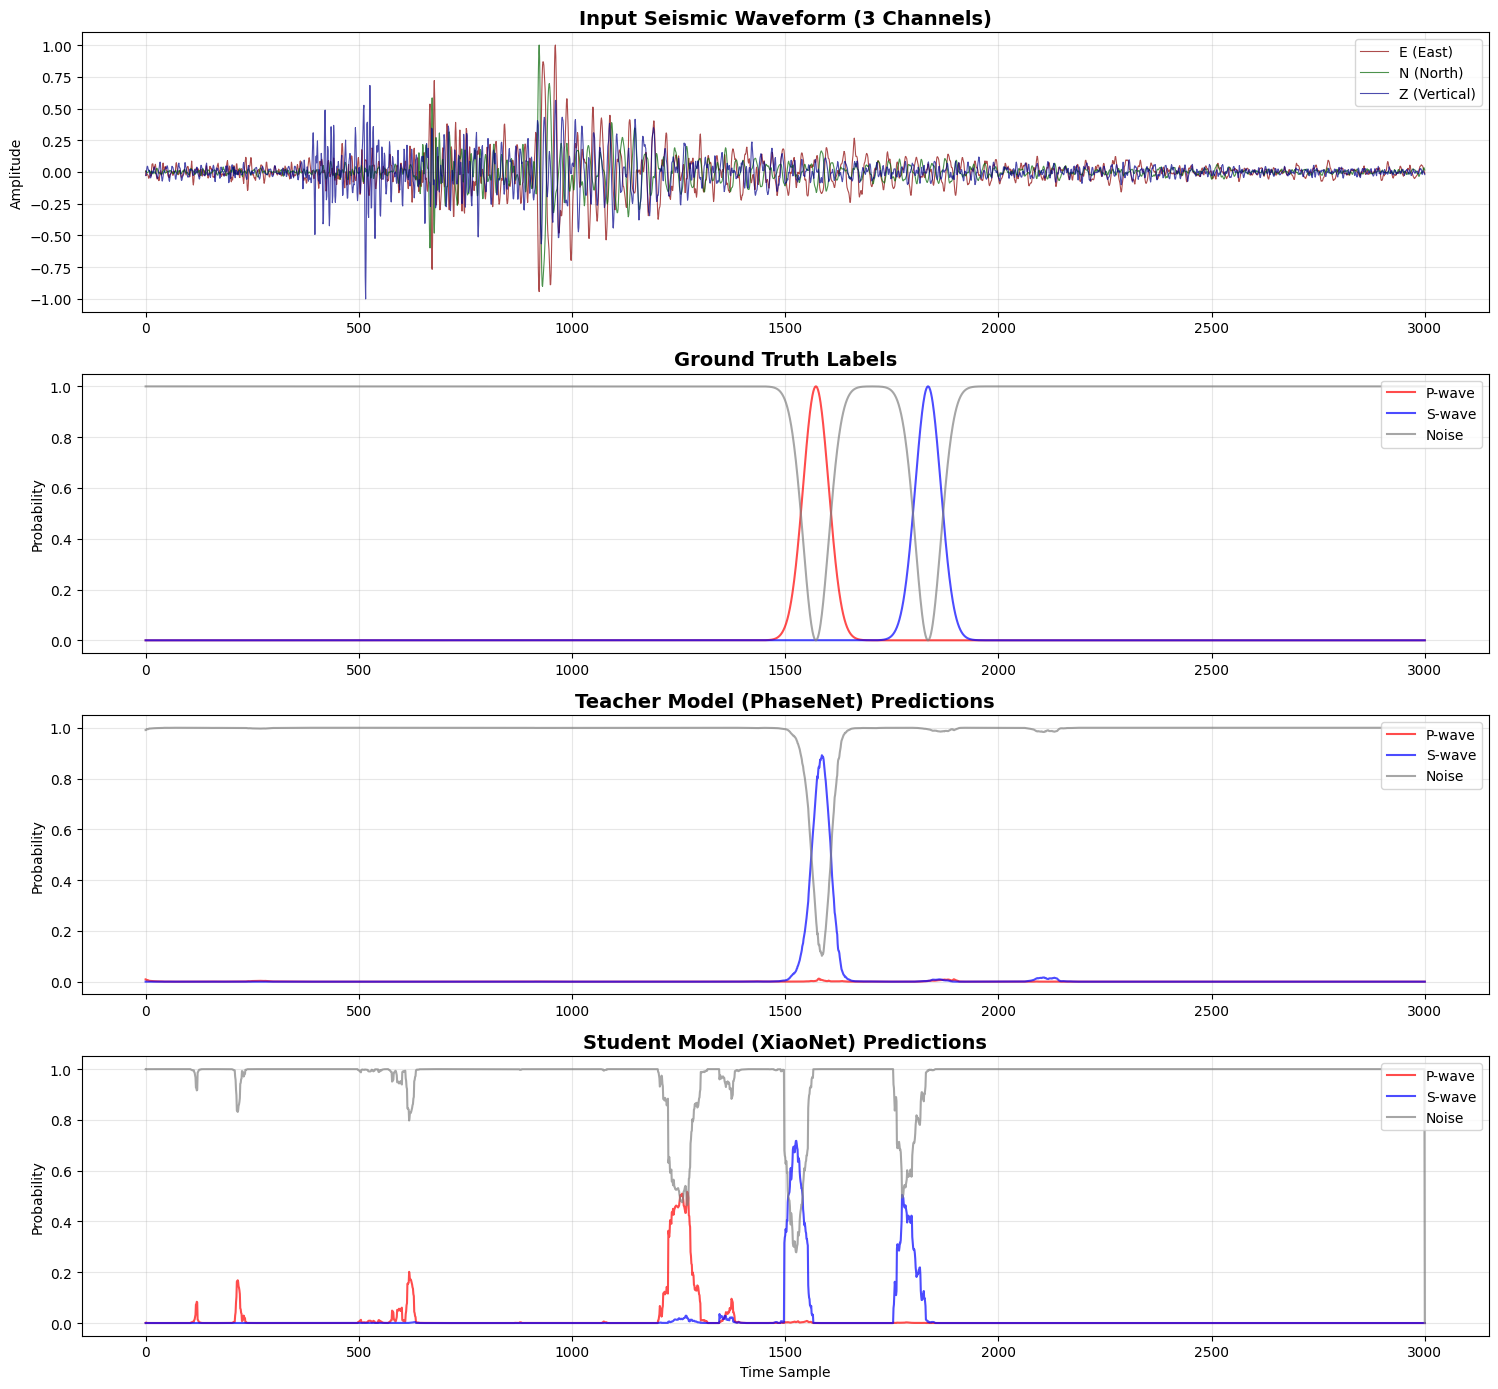

✓ Saved comparison plot: prediction_comparison_sample_0.png


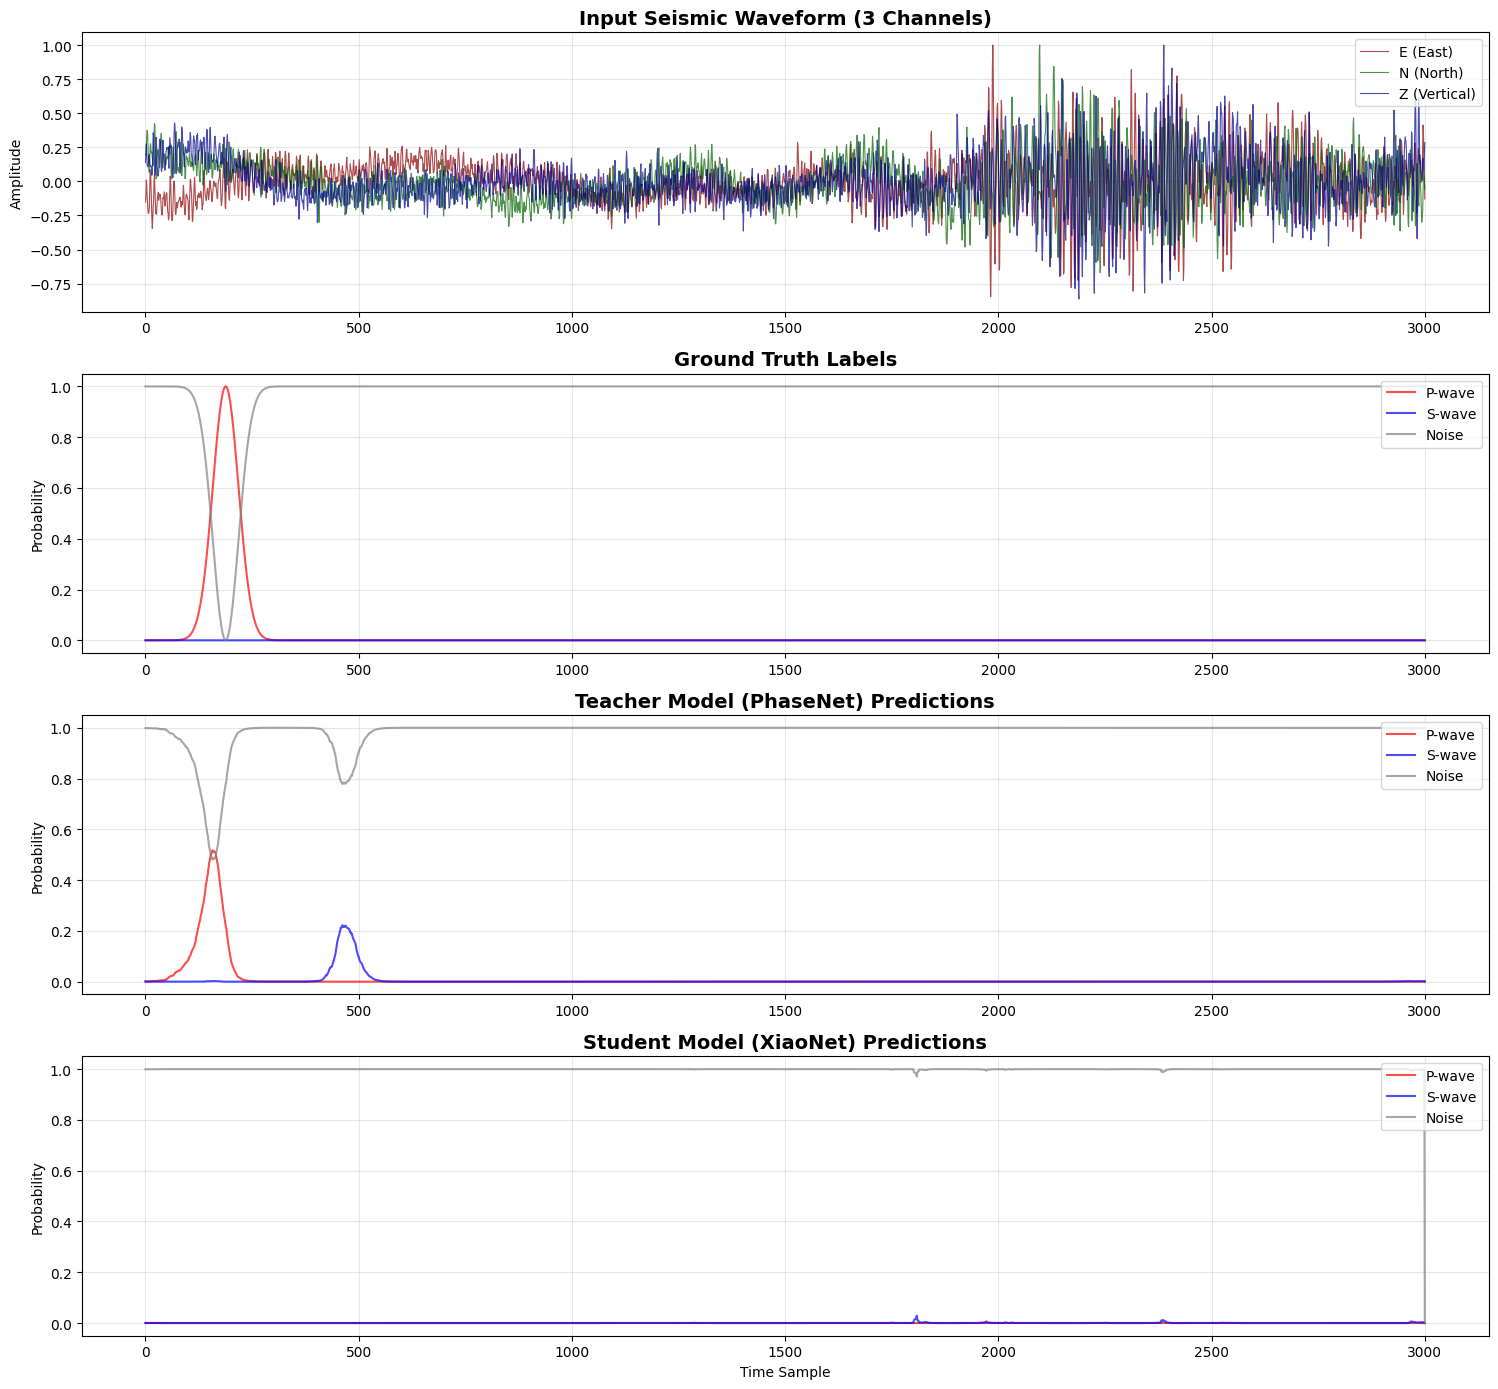

✓ Saved comparison plot: prediction_comparison_sample_1.png


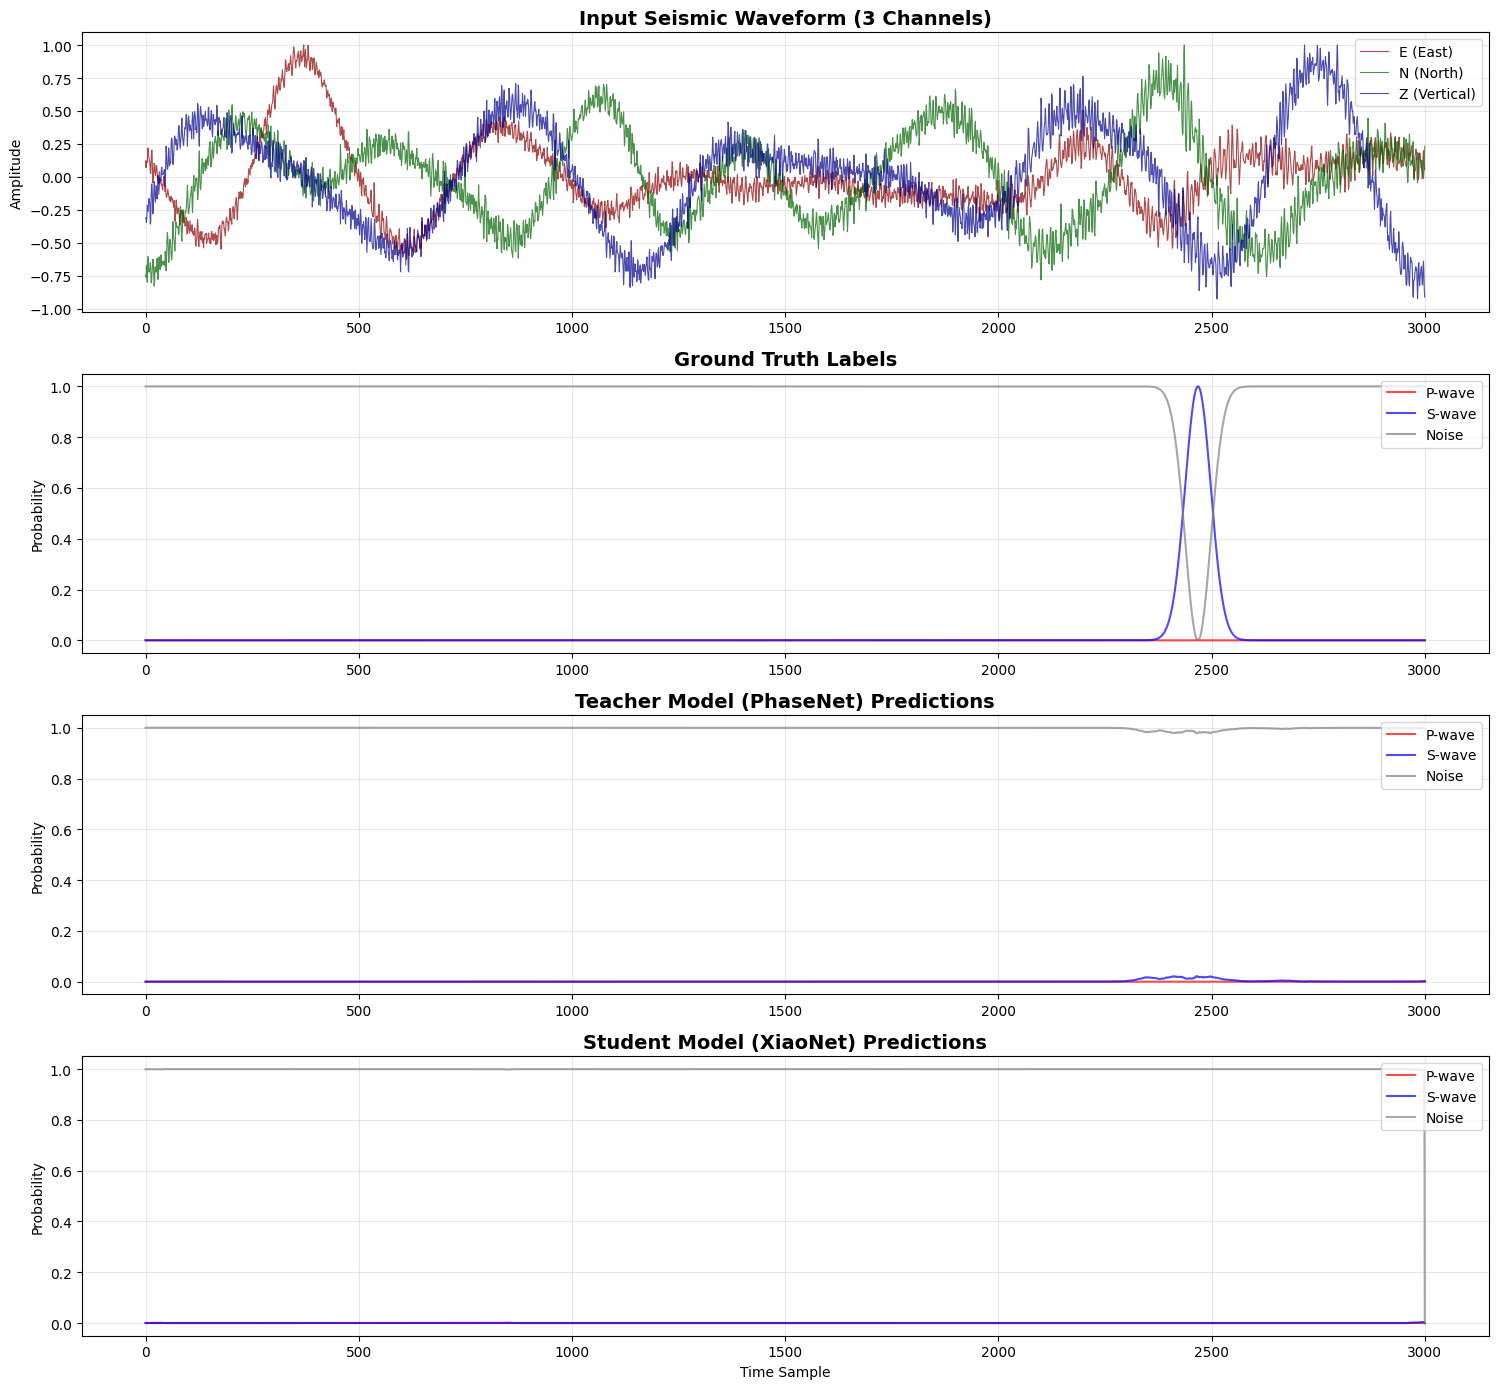

✓ Saved comparison plot: prediction_comparison_sample_2.png


In [61]:
# Visualize Predictions Comparison
import matplotlib.pyplot as plt

def plot_prediction_comparison(waveform, teacher_pred, student_pred, true_label, sample_idx=0):
    """
    Plot comparison of waveform, ground truth, and model predictions.
    
    Args:
        waveform: Input waveform data (batch, 3, time) - [E, N, Z channels]
        teacher_pred: Teacher model predictions (batch, 3, time)
        student_pred: Student model predictions (batch, 3, time)
        true_label: Ground truth labels (batch, 3, time)
        sample_idx: Which sample from the batch to visualize
    """
    fig, axes = plt.subplots(4, 1, figsize=(15, 14))
    
    class_names = ['P-wave', 'S-wave', 'Noise']
    colors = ['red', 'blue', 'gray']
    channel_names = ['E (East)', 'N (North)', 'Z (Vertical)']
    channel_colors = ['darkred', 'darkgreen', 'darkblue']
    
    # Plot 1: 3-channel waveform
    for i, (channel_name, color) in enumerate(zip(channel_names, channel_colors)):
        axes[0].plot(waveform[sample_idx, i, :].numpy(), 
                     label=channel_name, color=color, alpha=0.7, linewidth=0.8)
    axes[0].set_title('Input Seismic Waveform (3 Channels)', fontsize=14, fontweight='bold')
    axes[0].set_ylabel('Amplitude')
    axes[0].legend(loc='upper right')
    axes[0].grid(True, alpha=0.3)
    
    # Plot 2: Ground truth labels
    for i, (class_name, color) in enumerate(zip(class_names, colors)):
        axes[1].plot(true_label[sample_idx, i, :].numpy(), 
                     label=class_name, color=color, alpha=0.7, linewidth=1.5)
    axes[1].set_title('Ground Truth Labels', fontsize=14, fontweight='bold')
    axes[1].set_ylabel('Probability')
    axes[1].legend(loc='upper right')
    axes[1].grid(True, alpha=0.3)
    axes[1].set_ylim([-0.05, 1.05])
    
    # Plot 3: Teacher predictions
    for i, (class_name, color) in enumerate(zip(class_names, colors)):
        axes[2].plot(teacher_pred[sample_idx, i, :].numpy(), 
                     label=class_name, color=color, alpha=0.7, linewidth=1.5)
    axes[2].set_title('Teacher Model (PhaseNet) Predictions', fontsize=14, fontweight='bold')
    axes[2].set_ylabel('Probability')
    axes[2].legend(loc='upper right')
    axes[2].grid(True, alpha=0.3)
    axes[2].set_ylim([-0.05, 1.05])
    
    # Plot 4: Student predictions
    for i, (class_name, color) in enumerate(zip(class_names, colors)):
        axes[3].plot(student_pred[sample_idx, i, :].numpy(), 
                     label=class_name, color=color, alpha=0.7, linewidth=1.5)
    axes[3].set_title('Student Model (XiaoNet) Predictions', fontsize=14, fontweight='bold')
    axes[3].set_ylabel('Probability')
    axes[3].set_xlabel('Time Sample')
    axes[3].legend(loc='upper right')
    axes[3].grid(True, alpha=0.3)
    axes[3].set_ylim([-0.05, 1.05])
    
    plt.tight_layout()
    plt.savefig(f'prediction_comparison_sample_{sample_idx}.png', dpi=150, bbox_inches='tight')
    plt.show()
    
    print(f"✓ Saved comparison plot: prediction_comparison_sample_{sample_idx}.png")


# Get waveform data from test set
print("\n📊 Generating prediction comparison plots...")
print("   Extracting waveform data from test set...")

all_waveforms = []
with torch.no_grad():
    for batch in test_loader:
        all_waveforms.append(batch["X"].cpu())
        if len(all_waveforms) * batch["X"].shape[0] >= teacher_results['predictions'].shape[0]:
            break

all_waveforms = torch.cat(all_waveforms, dim=0)
print(f"   Waveform data shape: {all_waveforms.shape}")

# Plot first 3 samples
for i in range(min(3, teacher_results['predictions'].shape[0])):
    plot_prediction_comparison(
        all_waveforms,
        teacher_results['predictions'],
        student_results['predictions'],
        teacher_results['labels'],
        sample_idx=i
    )


In [62]:
# Performance Efficiency Metrics
print("=" * 70)
print("⚡ EFFICIENCY METRICS")
print("=" * 70)

# Calculate inference time
import time

def measure_inference_time(model, dataloader, device, num_batches=10):
    """Measure average inference time per batch."""
    model.eval()
    times = []
    
    with torch.no_grad():
        for i, batch in enumerate(dataloader):
            if i >= num_batches:
                break
            
            X = batch["X"].to(device)
            
            start_time = time.time()
            _ = model(X)
            end_time = time.time()
            
            times.append(end_time - start_time)
    
    return np.mean(times), np.std(times)

print("\n⏱️ Measuring inference time...")

teacher_time, teacher_std = measure_inference_time(teacher_model, test_loader, device)
student_time, student_std = measure_inference_time(student_model, test_loader, device)

print(f"\nTeacher Model (PhaseNet):")
print(f"  Avg inference time: {teacher_time*1000:.2f} ± {teacher_std*1000:.2f} ms/batch")
print(f"  Samples per second: {batch_size / teacher_time:.1f}")

print(f"\nStudent Model (XiaoNet):")
print(f"  Avg inference time: {student_time*1000:.2f} ± {student_std*1000:.2f} ms/batch")
print(f"  Samples per second: {batch_size / student_time:.1f}")

speedup = teacher_time / student_time
print(f"\n🚀 Speedup: {speedup:.2f}x faster")

# Compression ratio
print(f"\n💾 Compression Metrics:")
print(f"  Parameter reduction: {(1 - student_params/teacher_params)*100:.1f}%")
print(f"  Size reduction: {teacher_params/student_params:.1f}x smaller")

# Efficiency score (accuracy per parameter)
teacher_efficiency = teacher_results['accuracy'] / (teacher_params / 1e6)
student_efficiency = student_results['accuracy'] / (student_params / 1e6)

print(f"\n📈 Efficiency (Accuracy per Million Parameters):")
print(f"  Teacher: {teacher_efficiency:.4f}")
print(f"  Student: {student_efficiency:.4f}")
print(f"  Student is {student_efficiency/teacher_efficiency:.2f}x more parameter-efficient")

print("\n" + "=" * 70)
print("✓ Efficiency analysis complete!")
print("=" * 70)


⚡ EFFICIENCY METRICS

⏱️ Measuring inference time...

Teacher Model (PhaseNet):
  Avg inference time: 67.33 ± 35.42 ms/batch
  Samples per second: 950.5

Student Model (XiaoNet):
  Avg inference time: 153.50 ± 39.74 ms/batch
  Samples per second: 416.9

🚀 Speedup: 0.44x faster

💾 Compression Metrics:
  Parameter reduction: 38.8%
  Size reduction: 1.6x smaller

📈 Efficiency (Accuracy per Million Parameters):
  Teacher: 3.6133
  Student: 5.9101
  Student is 1.64x more parameter-efficient

✓ Efficiency analysis complete!
